# **Preprocessing of the PanNuke Dataset**

The [PanNuke](https://arxiv.org/pdf/2003.10778) dataset is designed for instance segmentation and classification of cell nuclei in histopathological images. It consists of **7,901 images** extracted from **19 different tissue types**, sourced from The Cancer Genome Atlas (TCGA) and other public repositories. It contains over **189,000 labeled nuclei instances**, categorized into five classes: **neoplastic, inflammatory, connective tissue, dead, and non-neoplastic epithelial**. The dataset's diversity in tissue types and the expert-annotated precision make it a valuable benchmark for developing and evaluating instance segmentation and classification algorithms in computational pathology.

## **Imports**

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
from tqdm.auto import tqdm
from google.colab import drive
import cv2
import yaml
import os

In [2]:
# Mount Google Drive in Colab
drive.mount("/content/drive")

Mounted at /content/drive


## **Parameters**

In [3]:
fold1_url = "https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_1.zip"
fold2_url = "https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_2.zip"
fold3_url = "https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_3.zip"
dataset_dir = "/content/PanNuke"
zip_dataset_path = "/content/drive/MyDrive/Datasets/PanNuke.zip"
imgsz = (512, 512)
val_size = 0.15
test_size = 0.15
SEED = 123

os.makedirs(dataset_dir, exist_ok=True)

## **Download and Extract Dataset**

The PanNuke dataset consists of **three folders**, each containing image files, masks, and tissue type information in **NPY** format. These files can be downloaded from its [official page](https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke).

In [ ]:
def download_extract_data(data_url):
  data_dir = tf.keras.utils.get_file(
      origin=data_url,
      cache_dir=os.getcwd(),
      extract=True
  )

  folder = os.path.basename(data_url).split("_")[1].split(".")[0]
  data_dir = os.path.join(data_dir, f"Fold {folder}")

  images_path = os.path.join(data_dir, f"images/fold{folder}/images.npy")
  masks_path = os.path.join(data_dir, f"masks/fold{folder}/masks.npy")
  tissues_path = os.path.join(data_dir, f"images/fold{folder}/types.npy")

  return images_path, masks_path, tissues_path

In [ ]:
images_path_fold1, masks_path_fold1, tissues_path_fold1 = download_extract_data(fold1_url)
images_path_fold2, masks_path_fold2, tissues_path_fold2 = download_extract_data(fold2_url)
images_path_fold3, masks_path_fold3, tissues_path_fold3 = download_extract_data(fold3_url)

700275281/700275281 ━━━━━━━━━━━━━━━━━━━━ 71s 0us/step
658842552/658842552 ━━━━━━━━━━━━━━━━━━━━ 87s 0us/step
717969882/717969882 ━━━━━━━━━━━━━━━━━━━━ 98s 0us/step


## **Preprocess the Dataset**

In this case, the three folders are merged and then split into **70% for training, 15% for validation, and 15% for testing**, ensuring that each set maintains the same proportion of cell nuclei for each tissue type. This preserves the data distribution across all three sets.  

Additionally, since the image and mask files are too large to be concatenated in **RAM** using the free version of **Google Colab**, a function is first created to concatenate large **NPY** files. Then, once the file is unified, it is loaded in **memory-mapping mode** (`mmap_mode="r"`) to access specific parts during preprocessing without having to load the entire file into **RAM**.

In [ ]:
# Function to concatenate large NPY files
def concat_npy_files(list_paths, path_save):

  # Load only the first file to obtain the shape and dtype
  first_array = np.load(list_paths[0], mmap_mode="r")
  dtype = first_array.dtype
  shape_single = first_array.shape[1:]

  # Calculate the total size of the new concatenated array
  total = sum(np.load(path, mmap_mode="r").shape[0] for path in list_paths)
  shape = (total,) + shape_single

  # Create a memmap file in write mode
  concat_array = np.lib.format.open_memmap(path_save, dtype=dtype, mode="w+", shape=shape)

  # Copy data from each file into the memmap array
  start_idx = 0
  for path in tqdm(list_paths):
    array = np.load(path, mmap_mode="r")
    end_idx = start_idx + array.shape[0]
    concat_array[start_idx:end_idx] = array
    start_idx = end_idx

    # Delete the individual NPY file
    os.remove(path)

  return np.load(path_save, mmap_mode="r")

In [ ]:
images = concat_npy_files([images_path_fold1, images_path_fold2, images_path_fold3], "images.npy")
masks = concat_npy_files([masks_path_fold1, masks_path_fold2, masks_path_fold3], "masks.npy")
tissues = concat_npy_files([tissues_path_fold1, tissues_path_fold2, tissues_path_fold3], "tissues.npy")

images.shape, masks.shape, tissues.shape

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

((7901, 256, 256, 3), (7901, 256, 256, 6), (7901,))

In [ ]:
# Show all tissue types
print(len(np.unique(tissues)))
np.unique(tissues)

19


array(['Adrenal_gland', 'Bile-duct', 'Bladder', 'Breast', 'Cervix',
       'Colon', 'Esophagus', 'HeadNeck', 'Kidney', 'Liver', 'Lung',
       'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Stomach', 'Testis',
       'Thyroid', 'Uterus'], dtype='<U13')

In [ ]:
# Split the dataset indices into training, validation, and testing
indices = np.arange(len(tissues))

train_indices, val_test_indices = train_test_split(
    indices,
    test_size= val_size + test_size,
    random_state=SEED, stratify=tissues
)
val_indices, test_indices = train_test_split(
    val_test_indices,
    test_size= test_size / (val_size + test_size),
    random_state=SEED, stratify=tissues[val_test_indices]
)

train_indices.shape, val_indices.shape, test_indices.shape

((5530,), (1185,), (1186,))

In [ ]:
# Ensure that the distribution of nuclei per tissue is proportional to the size of each set
train_count = np.unique(tissues[train_indices], return_counts=True)[1]
val_count = np.unique(tissues[val_indices], return_counts=True)[1]
test_count = np.unique(tissues[test_indices], return_counts=True)[1]

print((val_count / (train_count + val_count)).tolist())
print((test_count / (train_count + test_count)).tolist())

[0.1752021563342318, 0.17647058823529413, 0.1774193548387097, 0.17617617617617617, 0.17670682730923695, 0.17647058823529413, 0.175, 0.17484662576687116, 0.17543859649122806, 0.1736842105263158, 0.17834394904458598, 0.1774193548387097, 0.18072289156626506, 0.18064516129032257, 0.1761006289308176, 0.1774193548387097, 0.17964071856287425, 0.17708333333333334, 0.17721518987341772]
[0.1774193548387097, 0.17647058823529413, 0.1774193548387097, 0.17658829414707353, 0.17670682730923695, 0.17647058823529413, 0.1772853185595568, 0.17737003058103976, 0.17543859649122806, 0.17801047120418848, 0.17307692307692307, 0.1774193548387097, 0.17575757575757575, 0.17532467532467533, 0.1761006289308176, 0.1774193548387097, 0.1746987951807229, 0.17708333333333334, 0.17721518987341772]


In [ ]:
# Define the classes and their respective colors
class_names = {0: "neoplastic", 1: "inflammatory", 2: "connective", 3: "dead", 4: "epithelial"}
class_colors = {0: [255, 0, 0], 1: [0, 255, 0], 2: [0, 0, 255], 3: [255, 255, 0], 4: [255, 165, 0]}

In instance segmentation, verifying whether duplicate contours exist for a given instance is more complex compared to object detection. This is because some contours may differ slightly in one or more coordinates. As a result, simply adding them to a Python set would not detect them as duplicates.  

To address this issue, duplicates are identified by comparing the bounding box coordinates of each contour rather than the individual contour coordinates.

In [ ]:
# Function to remove duplicate labels
def remove_duplicates(labels):
  bboxes = set()
  unique_labels = []

  for label in labels:
    polygon = np.array(label[1:], dtype=np.float32).reshape(-1, 2)
    xmin, ymin = polygon.min(axis=0)
    xmax, ymax = polygon.max(axis=0)
    bbox = (xmin, ymin, xmax, ymax)

    if bbox not in bboxes:
      bboxes.add(bbox)
      unique_labels.append(label)

  return unique_labels


# Function to resize images in array format
def resize_image(image, size):
  image = tf.image.resize(image.astype(np.uint8), size, method="nearest")
  return image.numpy().squeeze()

For instance segmentation with [YOLO by Ultralytics](https://docs.ultralytics.com/datasets/segment/#ultralytics-yolo-format), each row in the label file corresponding to an image must follow this format:  

**`class_index, x1, y1, ..., xn, yn`**  

Where:  
- Each row represents an object instance.  
- The contour (polygon) coordinates are normalized within the range $[0, 1]$.  
- Each instance must have at least **three (X, Y) coordinate pairs**.  
- Each convex object must be represented by **a single contour**.  

In the PanNuke dataset, each segmentation mask has dimensions `(256, 256, 6)`, where the first two dimensions correspond to the image size (all images have the same size), and the third dimension represents the number of classes. The last channel (index `5`) corresponds to the background and is therefore ignored.  

Each class mask with dimensions `(256, 256)` contains one or more instances, represented by integer pixel values, where pixel `0` corresponds to the background, and the remaining values indicate specific instances of the respective class.  

To use these masks in YOLO, they must be converted into contour coordinates using OpenCV’s `cv2.findContours`. However, since the images and their segmentation masks are small, it is recommended to upscale them to a larger size, in this case `(512, 512)`, to prevent the loss of small object instances. This is because, when kept at their original size `(256, 256)`, some instances may be represented by only **two XY coordinates**, which prevents proper contour extraction.

In [ ]:
# Function to preprocess and save images and masks
def save_data(indices, split="train"):

  # Create the image and label directories
  images_dir = os.path.join(dataset_dir, split, "images")
  labels_dir = os.path.join(dataset_dir, split, "labels")

  os.makedirs(images_dir, exist_ok=True)
  os.makedirs(labels_dir, exist_ok=True)
  
  # Get the resizing dimensions and the number of classes
  height, width = imgsz
  num_classes = len(class_names)

  for idx in tqdm(indices):
    image = images[idx]
    mask = masks[idx]
    tissue = tissues[idx]

    filename = f"{tissue.replace('_', '-')}_{idx:04d}"
    labels = []

    for cls in range(num_classes):
      cls_mask = mask[..., cls]

      for i in np.unique(cls_mask):
        if i != 0:
          # Find the contours for each binary mask
          binary_mask = (cls_mask == i).astype(np.uint8)
          binary_mask = resize_image(binary_mask[..., None], imgsz)
          contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

          for contour in contours:
            if len(contour) < 3:
              print(f"Contour contains fewer than 3 (x, y) points in: {filename}")
              continue
            
            # Normalize the contour coordinates
            contour = contour.squeeze().astype(np.float32)
            contour[:, 0] /= width
            contour[:, 1] /= height
            contour = np.clip(contour, 0, 1)
            contour = contour.flatten().tolist()

            labels.append([cls] + contour)
    
    # Remove duplicate labels
    labels = remove_duplicates(labels)

    # Discard empty labels
    if not labels:
      print(f"No labels present in {filename}")
      continue
    
    # Save the images and labels
    with open(os.path.join(labels_dir, f"{filename}.txt"), "w") as file:
      file.writelines(" ".join(map(str, row)) + "\n" for row in labels)

    image = Image.fromarray(resize_image(image, imgsz))
    image.save(os.path.join(images_dir, f"{filename}.png"))

In [ ]:
save_data(train_indices)
save_data(val_indices, split="val")
save_data(test_indices, split="test")

  0%|          | 0/5530 [00:00<?, ?it/s]

No labels present in HeadNeck_4507
No labels present in Cervix_6255
No labels present in HeadNeck_2164
No labels present in HeadNeck_7167
No labels present in Cervix_6267
No labels present in Colon_7027
No labels present in Colon_4345
No labels present in Bile-duct_4091
No labels present in Bile-duct_4090
No labels present in Breast_4182
No labels present in Colon_4351
No labels present in Colon_6984
No labels present in Colon_7024
No labels present in Colon_4318
No labels present in Skin_2462
No labels present in Colon_0830
No labels present in Breast_0586
No labels present in Colon_0811
No labels present in HeadNeck_4503
No labels present in HeadNeck_4656
No labels present in HeadNeck_4505
No labels present in HeadNeck_4577
No labels present in Colon_0833
No labels present in Testis_3905
No labels present in Bile-duct_1578
No labels present in Cervix_6264
No labels present in Colon_5150
No labels present in Cervix_1164
No labels present in HeadNeck_4545
No labels present in Lung_2264

  0%|          | 0/1185 [00:00<?, ?it/s]

No labels present in Kidney_2176
No labels present in Cervix_6848
No labels present in Cervix_1750
No labels present in Colon_2636
No labels present in Colon_7874
No labels present in Bile-duct_4059
No labels present in Cervix_4215
No labels present in HeadNeck_4584
No labels present in Bile-duct_6687
No labels present in Colon_3408
No labels present in Colon_5914
No labels present in Skin_4966
No labels present in Cervix_1149
No labels present in Bile-duct_1619
No labels present in HeadNeck_2110
No labels present in Colon_4349
No labels present in Cervix_1753
No labels present in Colon_2640
No labels present in Colon_3409
No labels present in Colon_1967
No labels present in Colon_7037
No labels present in Colon_6982
No labels present in Colon_7031
No labels present in Colon_1880
No labels present in HeadNeck_4655
No labels present in Colon_2019
No labels present in Breast_6826
No labels present in Colon_4321
No labels present in Colon_4352
No labels present in Cervix_1152
No labels pr

  0%|          | 0/1186 [00:00<?, ?it/s]

No labels present in Breast_4180
No labels present in HeadNeck_4589
No labels present in Colon_1972
No labels present in Bile-duct_4092
No labels present in Colon_7030
No labels present in Colon_5963
No labels present in HeadNeck_7166
No labels present in Breast_0604
No labels present in Colon_7035
No labels present in Colon_4402
No labels present in Colon_4356
No labels present in Skin_4925
No labels present in Bile-duct_1614
No labels present in Bladder_4133
No labels present in HeadNeck_7303
No labels present in Colon_7041
No labels present in Colon_0832
No labels present in Colon_7014
No labels present in Colon_0828
No labels present in Colon_1512
No labels present in Colon_7073
No labels present in Lung_2263
No labels present in HeadNeck_7246
No labels present in Breast_1707
No labels present in HeadNeck_2108
No labels present in Colon_4341
No labels present in Colon_1975
No labels present in Colon_4354
No labels present in Colon_4340
No labels present in Colon_7012
No labels pres

In [ ]:
# Number of images and labels after preprocessing
print(
    len(os.listdir(os.path.join(dataset_dir, "train/images"))),
    len(os.listdir(os.path.join(dataset_dir, "train/labels")))
)

print(
    len(os.listdir(os.path.join(dataset_dir, "val/images"))),
    len(os.listdir(os.path.join(dataset_dir, "val/labels")))
)

print(
    len(os.listdir(os.path.join(dataset_dir, "test/images"))),
    len(os.listdir(os.path.join(dataset_dir, "test/labels")))
)

5293 5293
1128 1128
1137 1137


In [ ]:
# Create and save the YAML files with the dataset metadata
metadata = {
    "path": f"../{os.path.basename(dataset_dir)}",
    "train": "train/images",
    "val": "val/images",
    "names": class_names,
    "colors": class_colors
}

with open(os.path.join(dataset_dir, f"val_data.yaml"), "w") as file:
  yaml.dump(metadata, file, default_flow_style=False, sort_keys=False)

metadata["val"] = "test/images"
with open(os.path.join(dataset_dir, f"test_data.yaml"), "w") as file:
  yaml.dump(metadata, file, default_flow_style=False, sort_keys=False)

In [ ]:
# Compress the dataset into a zip file and save it
!zip -r $zip_dataset_path {os.path.basename(dataset_dir)} -q

## **Exploratory Data Analysis (EDA)**

In [ ]:
# Function to extract instance counts per class
def count_instances(data_dir):
  dic_classes = {name: 0 for name in class_names.values()}
  label_paths = glob(os.path.join(data_dir, "*.txt"))

  for path in tqdm(label_paths):
    with open(path, "r") as file:
      classes = [int(row.split()[0]) for row in file.readlines()]

    names = np.array(list(class_names.values()))[classes]
    for name in names:
      dic_classes[name] += 1

  df = pd.DataFrame(list(dic_classes.items()), columns=["Class", "Count"])
  return df

In [ ]:
num_train_instances = count_instances(os.path.join(dataset_dir, "train/labels"))
num_val_instances = count_instances(os.path.join(dataset_dir, "val/labels"))
num_test_instances = count_instances(os.path.join(dataset_dir, "test/labels"))

  0%|          | 0/5293 [00:00<?, ?it/s]

  0%|          | 0/1128 [00:00<?, ?it/s]

  0%|          | 0/1137 [00:00<?, ?it/s]

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.1 MB/s eta 0:00:00


In [ ]:
# Function to plot a barplot of class counts
def plot_counts(num_instances, split="training", renderer=None):
  num_instances = num_instances.sort_values(by="Count")
  fig = px.bar(
      num_instances, x="Count", y="Class", title="Counts of Classes",
      text="Count", color="Count",
      color_continuous_scale=[(0, "#D80000"), (0.5, "lightblue"), (1, "#003299")]
  )

  total_count = num_instances.Count.sum()
  fig.update_layout(
      title=dict(
          text=f"Class Count in the {split.capitalize()} (Total: {total_count})",
          font=dict(size=15, weight="bold"),
          x=0.5
      ),
      xaxis_title=dict(text="Frequency", font=dict(size=12, weight="bold")),
      yaxis_title=dict(text="Class", font=dict(size=12, weight="bold")),
      height=400,
      width=800
  )
  fig.show(renderer=renderer)

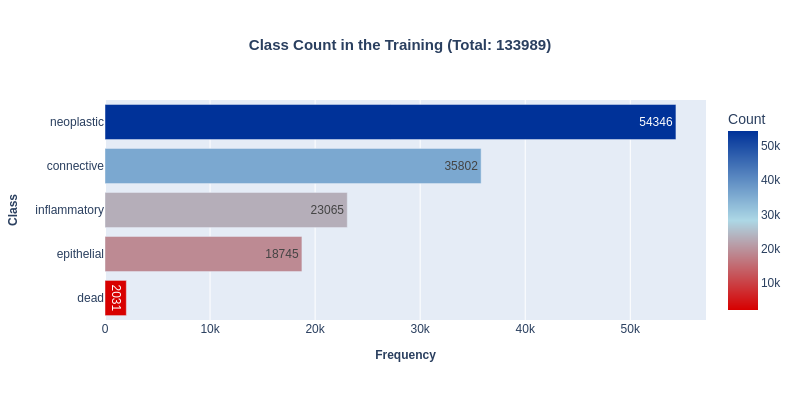

In [ ]:
plot_counts(num_train_instances)
plot_counts(num_train_instances, renderer="png")

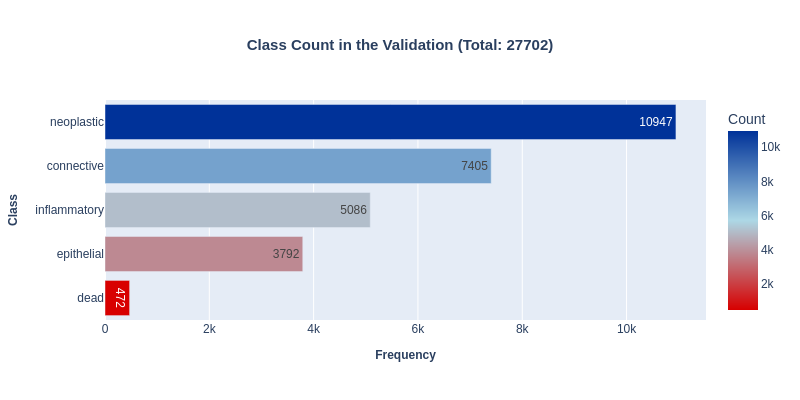

In [ ]:
plot_counts(num_val_instances, split="validation")
plot_counts(num_val_instances, split="validation", renderer="png")

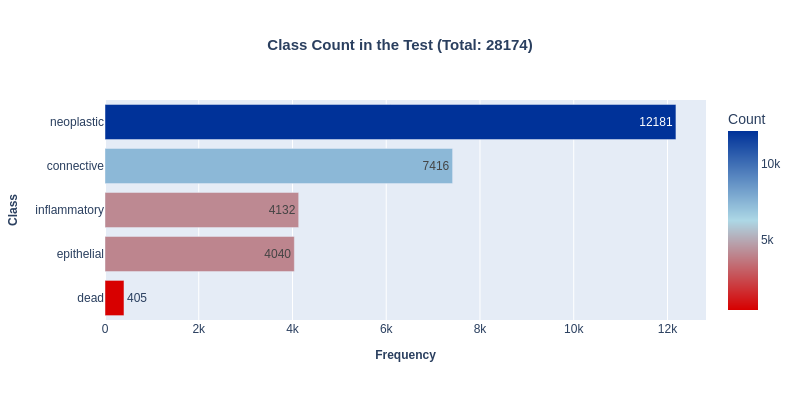

In [ ]:
plot_counts(num_test_instances, split="test")
plot_counts(num_test_instances, split="test", renderer="png")

From the bar plots, a significant class imbalance can be observed, with the most affected class being `dead`. Therefore, a model trained on the PanNuke dataset is expected to face greater challenges and achieve lower performance on this class.

In [ ]:
print(num_val_instances.Count / (num_train_instances.Count + num_val_instances.Count + num_test_instances.Count), "\n")
print(num_test_instances.Count / (num_train_instances.Count + num_val_instances.Count + num_test_instances.Count))

0    0.141299
1    0.157544
2    0.146277
3    0.162311
4    0.142680
Name: Count, dtype: float64 

0    0.157227
1    0.127993
2    0.146495
3    0.139271
4    0.152011
Name: Count, dtype: float64


It can be observed that the proportion of instances for each class remains approximately the same across the three sets.

## **Visualization Example**

In [6]:
image_paths = sorted(glob(os.path.join(dataset_dir, "train/images/*.png")))

In [ ]:
# Function to plot n images and their respective segmented instances
def plot_image_masks(image_paths, n_rows=2, n_cols=2, random=True):
  n_samples = int(n_rows * n_cols)
  if random:
    sample_images = np.random.choice(image_paths, n_samples, replace=False)
  else:
    sample_images = image_paths[:n_samples]

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.8, n_rows * 4.8))
  axes = axes.flatten() if n_samples > 1 else [axes]

  for i, path in enumerate(sample_images):
    image = np.array(Image.open(path))
    tissue = os.path.basename(path).split("_")[0].replace("-", " ")

    with open(path.replace("images", "labels").replace(".png", ".txt"), "r") as file:
      labels = [row.split() for row in file.readlines()]

    shape = image.shape
    axes[i].imshow(image)
    axes[i].set_title(tissue, fontsize=8.5, fontweight="bold")
    axes[i].axis("off")

    for label in labels:
      cls = int(label[0])
      color = class_colors[cls]
      color = tuple(np.array(color) / 255)

      contour = np.array(label[1:]).reshape(-1, 2).astype(np.float32)
      contour[:, 0] *= shape[1]
      contour[:, 1] *= shape[0]
      polygon = patches.Polygon(contour, facecolor=color, edgecolor=color, alpha=0.5, linewidth=1.5)

      xmin, ymin = contour.min(axis=0)
      xmax, ymax = contour.max(axis=0)
      rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1.5, edgecolor=color, facecolor="none")

      axes[i].add_patch(polygon)
      axes[i].add_patch(rect)
      axes[i].text(
          x=xmin, y=ymin, s=f"{class_names[cls]}",
          color="black", fontsize=7, fontweight="bold", ha="left", va="bottom",
          bbox={"boxstyle": "square,pad=0", "facecolor": color, "edgecolor": color, "alpha": 0.7}
      )

  plt.tight_layout()
  plt.show()

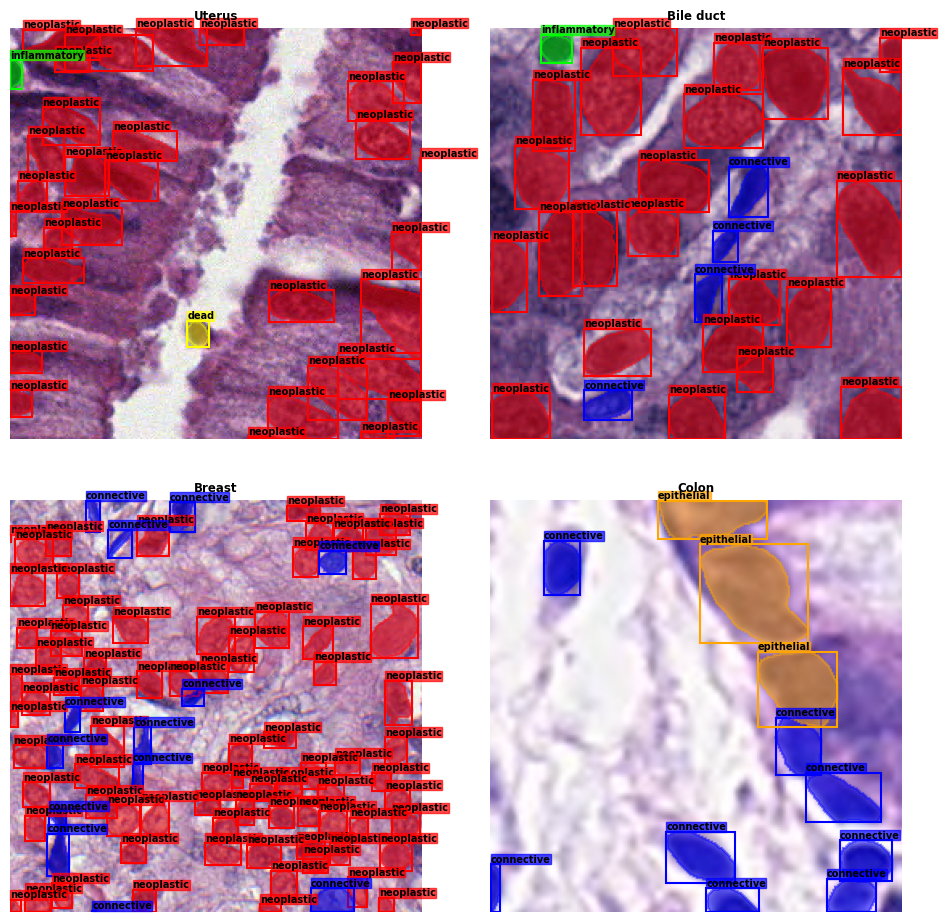

In [37]:
plot_image_masks(image_paths)